In [1]:
# env sctk2

%load_ext autoreload
%autoreload 2

import os, re, gc 
#joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sn
import anndata
import scanpy as sc
#import scvelo as scv
import sctk as sk
#import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
#from plotnine import ggplot, aes
#import plotnine as pln
from matplotlib.colors import ListedColormap

import matplotlib
import matplotlib.cm as cm

from statsmodels.stats.multitest import fdrcorrection

from scipy.stats import pearsonr, spearmanr

import scipy.sparse as sp

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.1 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
root_path = '/lustre/scratch126/cellgen/team298/hg6/Fetal_skin/data/final/'
save_path = '/home/jovyan/projects/skin/fetal_skin/'
sc.settings.figdir = save_path + 'figures/other plots/'

# Drivers of angiogenesis - VEGF, hypoxia genes, blood flow genes and VEGF receptor expression

## Load and configure pooled data

In [4]:
#load pooled prenatal skin, healthy adult and skin organoid object

pooled_object = 'pooled_fetal_organoid_adult.processed.h5ad'
pooled_path = root_path + pooled_object
pdata = sc.read(pooled_path)
pdata

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [5]:
print(list(pdata.obs['dataset'].unique()))

['fetal', 'organoid', 'adult']


In [6]:
#slice to prenetal/fetal skin only and remove genes with counts<1
keep1 = ['fetal']
pdata_fetal = pdata[pdata.obs['dataset'].isin(keep1)]
sc.pp.filter_genes(pdata_fetal, min_counts=1, min_cells=None, inplace=True)
pdata_fetal

filtered out 18015 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 186533 × 28779
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [7]:
#slice to organoid skin only and check 'day'
keep2 = ['organoid']
pdata_org = pdata[pdata.obs['dataset'].isin(keep2)]
print(list(pdata_org.obs['day'].unique()))

['day-133', 'day-29', 'day-48', 'day-85', 'day-13']


In [8]:
#slice skin organoid object to remove day-13 only and and remove genes with counts<1
pdata_org = pdata_org[pdata_org.obs['day']!='day-13']
print(list(pdata_org.obs['day'].unique()))
sc.pp.filter_genes(pdata_org, min_counts=1, min_cells=None, inplace=True)
pdata_org

['day-133', 'day-29', 'day-48', 'day-85']
filtered out 18681 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 114278 × 28113
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [9]:
#check data counts
pdata_fetal.X.data

array([2.2455943, 0.989481 , 0.989481 , ..., 1.6292564, 1.6292564, 1.6292564], dtype=float32)

In [10]:
pdata_fetal.X.max()

11.004526

In [11]:
pdata_org.X.data

array([0.6374563, 0.6374563, 0.6374563, ..., 1.36667  , 1.36667  , 1.36667  ], dtype=float32)

In [12]:
pdata_org.X.max()

8.528311

In [13]:
#re concatenate data
import anndata as ad

pdata2 = ad.concat([pdata_fetal, pdata_org],  join='outer')
pdata2

AnnData object with n_obs × n_vars = 300811 × 37520
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

In [14]:
# check annotations
print(list(pdata2.obs['joint_annotation_20220202'].unique()))
print(list(pdata2.obs['org_annot0'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LYVE1-hi LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating 

In [15]:
#create combined annotation column
pdata2.obs['new_combined_anno'] = pdata2.obs['joint_annotation_20220202']
cond = (pdata2.obs['new_combined_anno'] == 'nan')
pdata2.obs.loc[cond, 'new_combined_anno'] = pdata2.obs['org_annot0']
print(list(pdata2.obs['new_combined_anno'].unique()))

['LYVE1++ macrophage', 'Monocyte (activated/differentiating)', 'Eo/baso/mast cell progenitor', 'DC2', 'TREM2+ macrophage', 'Monocyte precursor', 'Monocyte', 'WNT2+ fibroblast', 'Iron-recycling macrophage', 'NK cell', 'B cell', 'LTi', 'ILC3', 'Inflammatory DC', 'MEMP - Early erythroid', 'CD4 T cell', 'Pro B cell', 'HSC', 'Pre B cell', 'MHCII+ macrophage', 'LYVE1-hi LE', 'Pre pro B cell', 'Innate T type1', 'CD8 T cell', 'Myocytes', 'pDC', 'Mast cell (most mature)', 'DC1', 'Mast cell (medium)', 'Capillaries', 'Neutrophil2', 'Capillary arterioles', 'LC', 'Megakaryocyte', 'MEMP - Megak', 'Mast cell (earliest)', 'Erythroid (fetal)', 'Myoblasts', 'Myofibroblasts', 'Pre-dermal condensate', 'HOXC5+ early fibroblast', 'PEAR1+ fibroblast', 'Pericytes', 'FRZB+ early fibroblast', 'Early erythroid (embryonic)', 'Early myocytes', 'Neuron progenitors', 'Myelinating Schwann cells', 'Schwann/Schwann precursors', 'LMCD1+ mural cell', 'PLN+ mural cell', 'ILC2', 'Lymphoid progenitor', 'SPP1+ proliferating 

In [16]:
#create new broad annotation column
pdata2.obs['new_broad_anno'] = pdata2.obs['new_combined_anno'].astype('category')

pdata2.obs.new_broad_anno.replace(
{
'LYVE1++ macrophage': 'immune',
'Monocyte (activated/differentiating)': 'immune',
'Eo/baso/mast cell progenitor': 'immune',
'DC2': 'immune',
'TREM2+ macrophage': 'immune',
'Monocyte precursor': 'immune',
'Monocyte': 'immune',
'WNT2+ fibroblast': 'dermal stroma',
'Iron-recycling macrophage': 'immune',
'NK cell': 'immune',
'B cell': 'immune',
'LTi': 'immune',
'ILC3': 'immune',
'Inflammatory DC': 'immune',
'MEMP - Early erythroid': 'erythroid',
'CD4 T cell': 'immune',
'Pro B cell': 'immune',
'HSC': 'immune',
'Pre B cell': 'immune',
'MHCII+ macrophage': 'immune',
'LYVE1-hi LE': 'endothelium',
'Pre pro B cell': 'immune',
'Innate T type1': 'immune',
'CD8 T cell': 'immune',
'Myocytes': 'muscle',
'pDC': 'immune',
'Mast cell (most mature)': 'immune',
'DC1': 'immune',
'Mast cell (medium)': 'immune',
'Capillaries': 'endothelium',
'Neutrophil2': 'immune',
'Capillary arterioles': 'endothelium',
'LC': 'immune',
'Megakaryocyte': 'immune',
'MEMP - Megak': 'immune',
'Mast cell (earliest)': 'immune',
'Erythroid (fetal)': 'erythroid',
'Myoblasts': 'muscle',
'Myofibroblasts': 'dermal stroma',
'Pre-dermal condensate': 'dermal stroma',
'HOXC5+ early fibroblast': 'dermal stroma',
'PEAR1+ fibroblast': 'dermal stroma',
'Pericytes': 'dermal stroma',
'FRZB+ early fibroblast': 'dermal stroma',
'Early erythroid (embryonic)': 'erythroid',
'Early myocytes': 'muscle',
'Neuron progenitors': 'neuronal',
'Myelinating Schwann cells': 'neuronal',
'Schwann/Schwann precursors': 'neuronal',
'LMCD1+ mural cell': 'dermal stroma',
'PLN+ mural cell': 'dermal stroma',
'ILC2': 'immune',
'Lymphoid progenitor': 'immune',
'SPP1+ proliferating neuron progenitors': 'neuronal',
'Adipocytes': 'dermal stroma',
'Neutrophil1': 'immune',
'Postcapillary venules': 'endothelium',
'PID1+ schwann cellls': 'neuronal',
'PROX1-hi LE': 'endothelium',
'Neuroendocrine': 'neuronal',
'Innate T type3': 'immune',
'Treg': 'immune',
'ASDC': 'immune',
'Early endothelial cells': 'endothelium',
'Periderm': 'epidermal',
'Melanocyte': 'epidermal',
'Melanoblast': 'epidermal',
'Dermal condensate': 'dermal stroma',
'Arterioles': 'endothelium',
'Immature basal': 'epidermal',
'Early erythroid': 'erythroid',
'Immature suprabasal': 'epidermal',
'Erythroid (embryonic)': 'erythroid',
'Venules': 'endothelium',
'Dermal papilla': 'dermal stroma',
'DPYSL2+ basal': 'epidermal',
'Outer root sheath': 'epidermal',
'Cuticle/cortex': 'epidermal',
'Placode/matrix': 'epidermal',
'POSTN+ basal': 'epidermal',
'Suprabasal IFE': 'epidermal',
'Companion layer': 'epidermal',
'Inner root sheath': 'epidermal',
'organoid_Fibroblasts POSTN+': 'organoid_dermal stroma',
'organoid_Dermal condensate': 'organoid_dermal stroma',
'organoid_Pre-dermal condensate': 'organoid_dermal stroma',
'organoid_Placode/matrix': 'organoid_epidermal',
'organoid_Basal': 'organoid_epidermal',
'organoid_Outer root sheath': 'organoid_epidermal',
'organoid_Basal POSTN+': 'organoid_epidermal',
'organoid_Adipocytes': 'organoid_dermal stroma',
'organoid_Inner root sheath': 'organoid_epidermal',
'organoid_Dermal papilla': 'organoid_dermal stroma',
'organoid_Cuticle/cortex': 'organoid_epidermal',
'organoid_Suprabasal IFE': 'organoid_epidermal',
'organoid_Companion layer': 'organoid_epidermal',
'organoid_Smooth muscle/Pericytes': 'organoid_muscle',
'organoid_Melanoblasts': 'organoid_epidermal',
'organoid_Melanocytes': 'organoid_epidermal',
'organoid_Secreting neuron': 'organoid_neuronal',
'organoid_Proliferating melanoblasts': 'organoid_epidermal',
'organoid_Early fibroblasts HOXC5+': 'organoid_dermal stroma',
'organoid_Schwann cells/Schwann precursors': 'organoid_neuronal',
'organoid_Myelinating Schwann cells': 'organoid_neuronal',
'organoid_Immature basal': 'organoid_epidermal',
'organoid_Myocytes': 'organoid_muscle',
'organoid_Early fibroblasts FRZB+': 'organoid_dermal stroma',
'organoid_Capillary arterioles': 'orgnoid_endothelium',
'organoid_Neuron progenitors SPP1+': 'organoid_neuronal',
'organoid_Periderm': 'organoid_epidermal',
'organoid_Neuroepithelial cells': 'organoid_neuronal',
'organoid_Immature suprabasal': 'organoid_epidermal',
'organoid_Merkel cells': 'organoid_epidermal',
'organoid_Early myocytes': 'organoid_muscle',
'organoid_Neuron progenitors': 'organoid_neuronal',
'organoid_Myoblasts': 'organoid_muscle',
}, inplace=True)

list(pdata2.obs['new_broad_anno'].unique())

['immune',
 'dermal stroma',
 'erythroid',
 'endothelium',
 'muscle',
 'neuronal',
 'epidermal',
 'organoid_dermal stroma',
 'organoid_epidermal',
 'organoid_muscle',
 'organoid_neuronal',
 'orgnoid_endothelium']

## VEGF genes per broad cell grouping

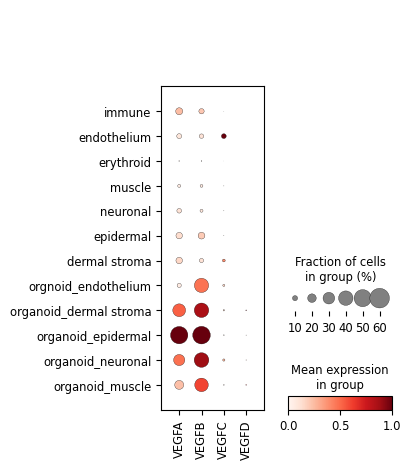

In [17]:
sc.pl.dotplot(pdata2, var_names=['VEGFA', 'VEGFB', 'VEGFC', 'VEGFD'],
              groupby='new_broad_anno', standard_scale='var')

## Hypoxia-related genes

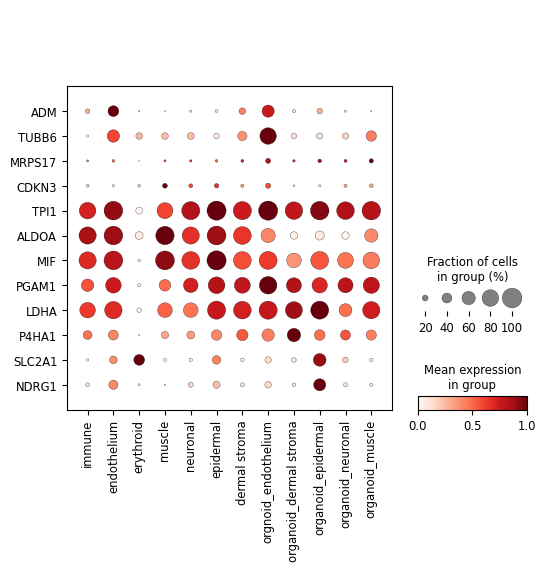

In [18]:
hypoxia_genes = ['ADM', 'TUBB6', 'MRPS17', 'CDKN3', 'TPI1', 'ALDOA', 'MIF', 'PGAM1', 'LDHA', 'P4HA1', 'SLC2A1', 'NDRG1']

sc.pl.dotplot(pdata2, var_names=hypoxia_genes,
              groupby='new_broad_anno', standard_scale='var', swap_axes=True)

## Plot hypoxia related genes in subset of cells

In [19]:
list(pdata2.obs['new_combined_anno'].unique())

['LYVE1++ macrophage',
 'Monocyte (activated/differentiating)',
 'Eo/baso/mast cell progenitor',
 'DC2',
 'TREM2+ macrophage',
 'Monocyte precursor',
 'Monocyte',
 'WNT2+ fibroblast',
 'Iron-recycling macrophage',
 'NK cell',
 'B cell',
 'LTi',
 'ILC3',
 'Inflammatory DC',
 'MEMP - Early erythroid',
 'CD4 T cell',
 'Pro B cell',
 'HSC',
 'Pre B cell',
 'MHCII+ macrophage',
 'LYVE1-hi LE',
 'Pre pro B cell',
 'Innate T type1',
 'CD8 T cell',
 'Myocytes',
 'pDC',
 'Mast cell (most mature)',
 'DC1',
 'Mast cell (medium)',
 'Capillaries',
 'Neutrophil2',
 'Capillary arterioles',
 'LC',
 'Megakaryocyte',
 'MEMP - Megak',
 'Mast cell (earliest)',
 'Erythroid (fetal)',
 'Myoblasts',
 'Myofibroblasts',
 'Pre-dermal condensate',
 'HOXC5+ early fibroblast',
 'PEAR1+ fibroblast',
 'Pericytes',
 'FRZB+ early fibroblast',
 'Early erythroid (embryonic)',
 'Early myocytes',
 'Neuron progenitors',
 'Myelinating Schwann cells',
 'Schwann/Schwann precursors',
 'LMCD1+ mural cell',
 'PLN+ mural cell',
 '

In [20]:
# slice data object to keep cells of interest

subset_keep = [
'Adipocytes', 
'DPYSL2+ basal',
'Companion layer',
'Cuticle/cortex', 
'Dermal condensate',
'Dermal papilla',  
'Early myocytes',
'Immature basal',
'Immature suprabasal',
'Inner root sheath',
'Myelinating Schwann cells',
'Myoblasts',
'Myocytes',
'Neuron progenitors',
'Outer root sheath',
'Periderm',
'Pre-dermal condensate',
'Suprabasal IFE',

'organoid_Adipocytes',
'organoid_Basal',
'organoid_Companion layer',
'organoid_Cuticle/cortex',
 'organoid_Dermal condensate',   
 'organoid_Dermal papilla',
 'organoid_Early myocytes',
 'organoid_Immature basal',
 'organoid_Immature suprabasal',
 'organoid_Inner root sheath',
 'organoid_Myelinating Schwann cells',
 'organoid_Myoblasts',
 'organoid_Myocytes',
 'organoid_Neuron progenitors',
 'organoid_Outer root sheath',
 'organoid_Periderm',
 'organoid_Pre-dermal condensate',
 'organoid_Suprabasal IFE',
 'organoid_Basal POSTN+',
 'organoid_Placode/matrix',
 'organoid_Early fibroblasts FRZB+',
 'organoid_Early fibroblasts HOXC5+',
 'organoid_Fibroblasts POSTN+',
 'organoid_Melanoblasts',
 'organoid_Melanocytes',
 'organoid_Merkel cells',
 'organoid_Neuroepithelial cells',
 'organoid_Neuron progenitors SPP1+',
'organoid_Proliferating melanoblasts',
'organoid_Schwann cells/Schwann precursors',
 'organoid_Secreting neuron',
 'organoid_Smooth muscle/Pericytes'
]

pdata2_subset = pdata2[pdata2.obs['new_combined_anno'].isin(subset_keep)]

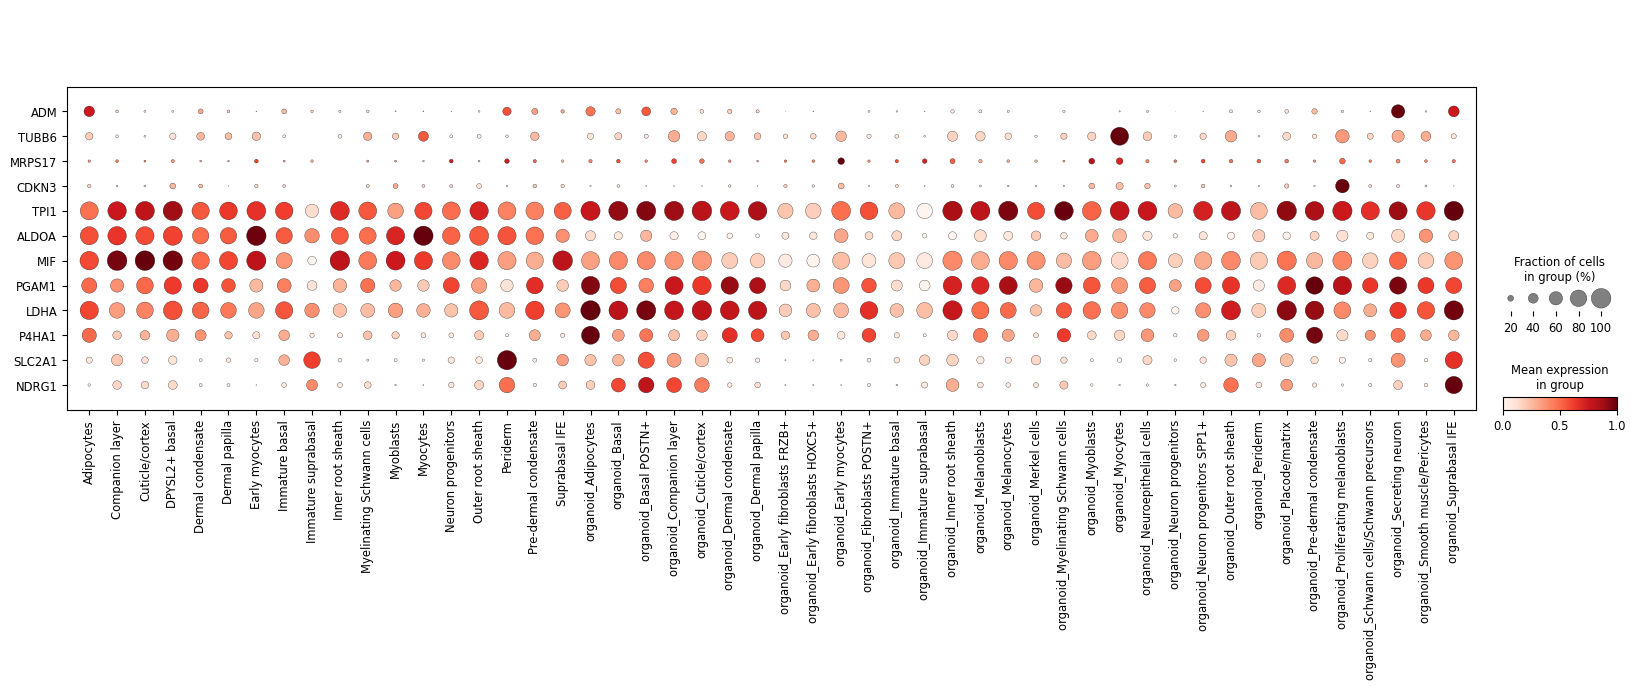

In [21]:
#plot hypoxia-related genes
sc.pl.dotplot(pdata2_subset, var_names=hypoxia_genes,
              groupby='new_combined_anno', standard_scale='var', swap_axes=True)

## Hypoxia gene scores

### Compute gene module scores across whole data object

In [22]:
gene_list = hypoxia_genes
print(len(gene_list))
sc.tl.score_genes(pdata2, gene_list, ctrl_size=100, gene_pool=None, n_bins=25, score_name='hypoxia_score', random_state=0, copy=False)

12
computing score 'hypoxia_score'
    finished: added
    'hypoxia_score', score of gene set (adata.obs).
    500 total control genes are used. (0:00:10)


### Plot angiogenesis gene module scores

In [23]:
#create data for plotting
scores_hypoxia = pdata2.obs.loc[:,['dataset', 'new_broad_anno', 'hypoxia_score']]
scores_hypoxia

,dataset,new_broad_anno,hypoxia_score
AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal,fetal,immune,0.362057
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal,fetal,immune,0.622053
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal,fetal,immune,0.414290
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal,fetal,immune,0.618523
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal,fetal,immune,0.623492
...,...,...,...
TTTGTCACAGCGAACA-1-11-organoid,organoid,organoid_dermal stroma,1.073776
TTTGTCACATGACATC-1-11-organoid,organoid,organoid_dermal stroma,0.774388
TTTGTCACATGCCCGA-1-11-organoid,organoid,organoid_dermal stroma,0.906917
TTTGTCATCAGGCAAG-1-11-organoid,organoid,organoid_dermal stroma,0.823629


In [25]:
scores_hypoxia['new_broad_anno2'] = scores_hypoxia['new_broad_anno'].str.split('_').str[1]
scores_hypoxia['new_broad_anno2'] = scores_hypoxia['new_broad_anno2'].fillna(scores_hypoxia.pop('new_broad_anno'))
scores_hypoxia

,dataset,hypoxia_score,new_broad_anno2
AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal,fetal,0.362057,immune
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal,fetal,0.622053,immune
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal,fetal,0.414290,immune
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal,fetal,0.618523,immune
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal,fetal,0.623492,immune
...,...,...,...
TTTGTCACAGCGAACA-1-11-organoid,organoid,1.073776,dermal stroma
TTTGTCACATGACATC-1-11-organoid,organoid,0.774388,dermal stroma
TTTGTCACATGCCCGA-1-11-organoid,organoid,0.906917,dermal stroma
TTTGTCATCAGGCAAG-1-11-organoid,organoid,0.823629,dermal stroma


In [27]:
print(scores_hypoxia['new_broad_anno2'].unique())

['immune' 'dermal stroma' 'erythroid' 'endothelium' 'muscle' 'neuronal' 'epidermal']


In [28]:
#Keep common cell groups
keep_broad = ['dermal stroma', 'endothelium', 'muscle', 'neuronal', 'epidermal']
scores_hypoxia_sub = scores_hypoxia[scores_hypoxia['new_broad_anno2'].isin(keep_broad)]
scores_hypoxia_sub

,dataset,hypoxia_score,new_broad_anno2
ACACCCTGTCGTTGTA-1-4834STDY7002879-fetal,fetal,0.826156,dermal stroma
ACTGTCCGTAGCGATG-1-4834STDY7002879-fetal,fetal,0.291942,dermal stroma
AGCGGTCAGCTTCGCG-1-4834STDY7002879-fetal,fetal,0.172862,dermal stroma
AGGCCGTTCCAGATCA-1-4834STDY7002879-fetal,fetal,0.963807,endothelium
AGTGAGGCAAAGTGCG-1-4834STDY7002879-fetal,fetal,0.816420,dermal stroma
...,...,...,...
TTTGTCACAGCGAACA-1-11-organoid,organoid,1.073776,dermal stroma
TTTGTCACATGACATC-1-11-organoid,organoid,0.774388,dermal stroma
TTTGTCACATGCCCGA-1-11-organoid,organoid,0.906917,dermal stroma
TTTGTCATCAGGCAAG-1-11-organoid,organoid,0.823629,dermal stroma


In [29]:
# obtain mean score per cell category and z-score data
score_mean_hypoxia_sub = scores_hypoxia_sub.groupby(['dataset', 'new_broad_anno2'])['hypoxia_score'].mean().to_frame()
score_mean_hypoxia_sub

hypoxia_score
dataset  new_broad_anno2               
fetal    dermal stroma         0.395691
         endothelium           0.559625
         epidermal             0.536542
         muscle                0.430885
         neuronal              0.351794
organoid dermal stroma         0.335149
         endothelium           0.489358
         epidermal             0.474223
         muscle                0.346536
         neuronal              0.253757

In [30]:
#Z_score the data
score_mean_hypoxia_sub= (score_mean_hypoxia_sub - score_mean_hypoxia_sub.mean())/score_mean_hypoxia_sub.std()
score_mean_hypoxia_sub

hypoxia_score
dataset  new_broad_anno2               
fetal    dermal stroma        -0.221181
         endothelium           1.452422
         epidermal             1.216777
         muscle                0.138115
         neuronal             -0.669324
organoid dermal stroma        -0.839247
         endothelium           0.735065
         epidermal             0.580554
         muscle               -0.722999
         neuronal             -1.670181

In [31]:
#compute min, max and mid values
max_val_hypoxia_sub = (max((np.array(score_mean_hypoxia_sub)).max(0)))
min_val_hypoxia_sub = (min((np.array(score_mean_hypoxia_sub)).min(0)))
mid_val_hypoxia_sub = (max((np.array(score_mean_hypoxia_sub)).max(0))) - ((max((np.array(score_mean_hypoxia_sub)).max(0))) - (min((np.array(score_mean_hypoxia_sub)).min(0))))/2

In [32]:
score_mean_hypoxia_sub

hypoxia_score
dataset  new_broad_anno2               
fetal    dermal stroma        -0.221181
         endothelium           1.452422
         epidermal             1.216777
         muscle                0.138115
         neuronal             -0.669324
organoid dermal stroma        -0.839247
         endothelium           0.735065
         epidermal             0.580554
         muscle               -0.722999
         neuronal             -1.670181

In [33]:
score_mean_hypoxia_sub_plot = score_mean_hypoxia_sub.pivot_table(index='dataset', columns='new_broad_anno2', values='hypoxia_score', sort=False)
score_mean_hypoxia_sub_plot

new_broad_anno2,dermal stroma,endothelium,epidermal,muscle,neuronal
dataset,,,,,
fetal,-0.221181,1.452422,1.216777,0.138115,-0.669324
organoid,-0.839247,0.735065,0.580554,-0.722999,-1.670181


In [34]:
sc.settings.set_figure_params(dpi=150, dpi_save=1000)
sn.set(font_scale=0.7)
pal3 = sn.diverging_palette(240, 10, n=7)

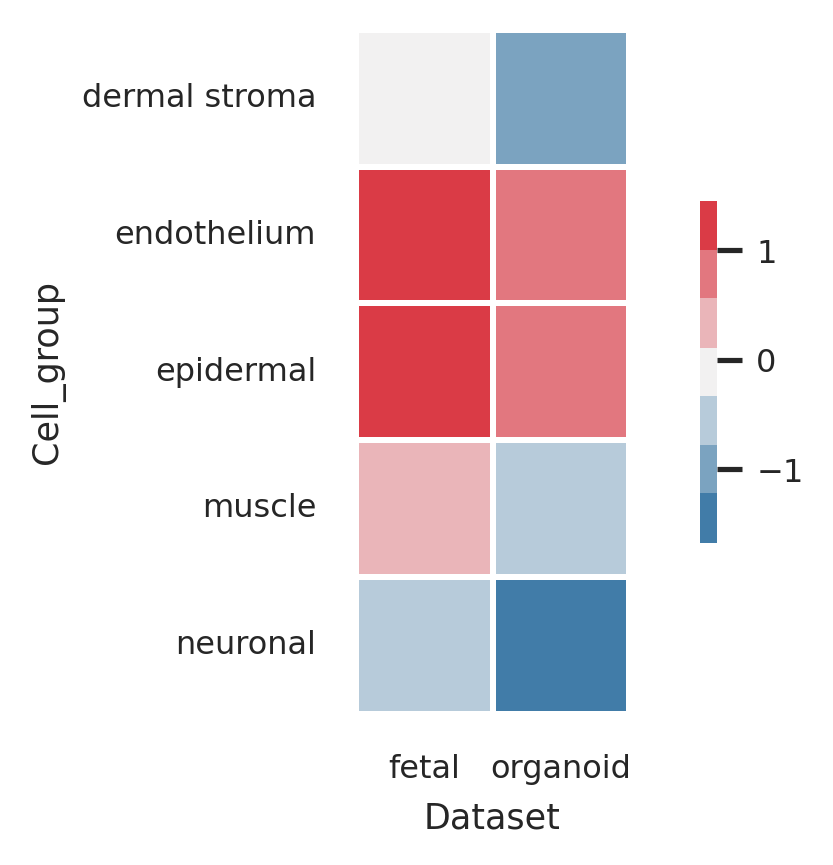

In [37]:
with matplotlib.rc_context({'figure.figsize' : (6,3)}):
    n = sn.heatmap(score_mean_hypoxia_sub_plot.T, cmap=pal3, annot=False, vmin=min_val_hypoxia_sub, vmax=max_val_hypoxia_sub, linewidths=1, center=mid_val_hypoxia_sub, 
                square=True, cbar_kws={"shrink": 0.5})
plt.ylabel("Cell_group")
plt.xlabel("Dataset")
#plt.savefig('/home/jovyan/projects/skin/fetal_skin/figures/hypoxia_geneset.pdf',dpi=300, bbox_inches = "tight")

## Blood flow related genes - capillary arterioles

In [38]:
#Check genes related to blood flow in endothelial cells
#Slice data object to only keep endothelial cells common to both prenatal skin and skin organoid - ie capillary aterioles

cap_arterioles = ['Capillary arterioles', 'organoid_Capillary arterioles']

pdata2_caparterioles = pdata2[pdata2.obs['new_combined_anno'].isin(cap_arterioles)]
pdata2_caparterioles

View of AnnData object with n_obs × n_vars = 264 × 37520
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo'

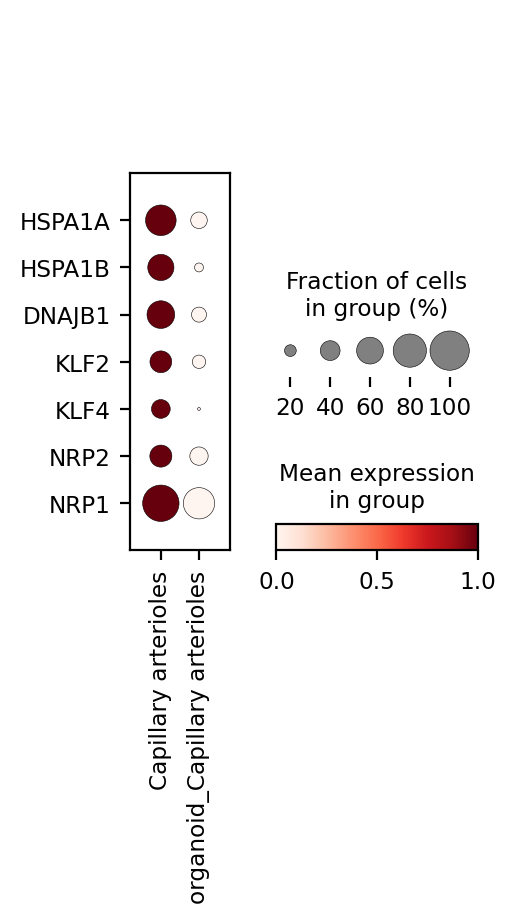

In [41]:
plt.rcdefaults()

#PLot expression of blood flow related genes in capillary arterioles comparing prenatal skin and skin organoid
blood_flow_genes = ['HSPA1A', 'HSPA1B', 'DNAJB1', 'KLF2', 'KLF4', 'NRP2', 'NRP1']

sc.pl.dotplot(pdata2_caparterioles, var_names=blood_flow_genes,
              groupby='new_combined_anno', standard_scale='var', swap_axes=True)

## VEGF receptors in capillary arterioles

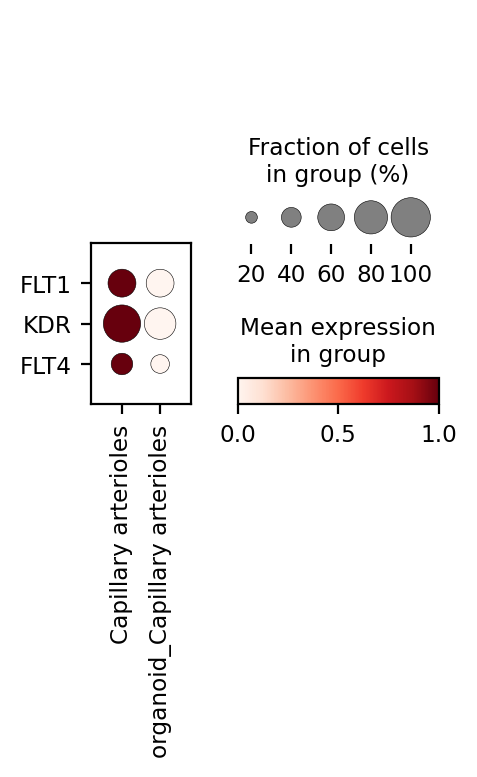

In [42]:
#Check VEGF receptors in endothelial cells
#Plot using data object containing only endothelial cells common to both prenatal skin and skin organoid - ie capillary aterioles - as above

VEGFR_genes = ['FLT1', 'KDR', 'FLT4']

sc.pl.dotplot(pdata2_caparterioles, var_names=VEGFR_genes,
              groupby='new_combined_anno', standard_scale='var', swap_axes=True)

# Endothelial pseudotime genes in capillary arterioles

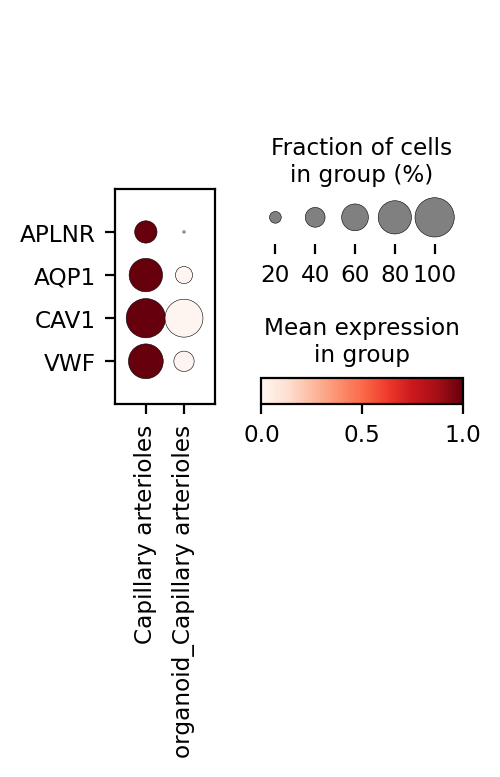

In [48]:
#Check pseudotime genes related to endothelial cell differentiation - downstream of GATA2 and SOX7
#Plot using data object containing only endothelial cells common to both prenatal skin and skin organoid - ie capillary aterioles - as above

pseudotime_genes = ['APLNR', 'AQP1', 'CAV1', 'VWF']

sc.pl.dotplot(pdata2_caparterioles, var_names=pseudotime_genes,
              groupby='new_combined_anno', standard_scale='var', swap_axes=True, save='pseudotime_genes.pdf')

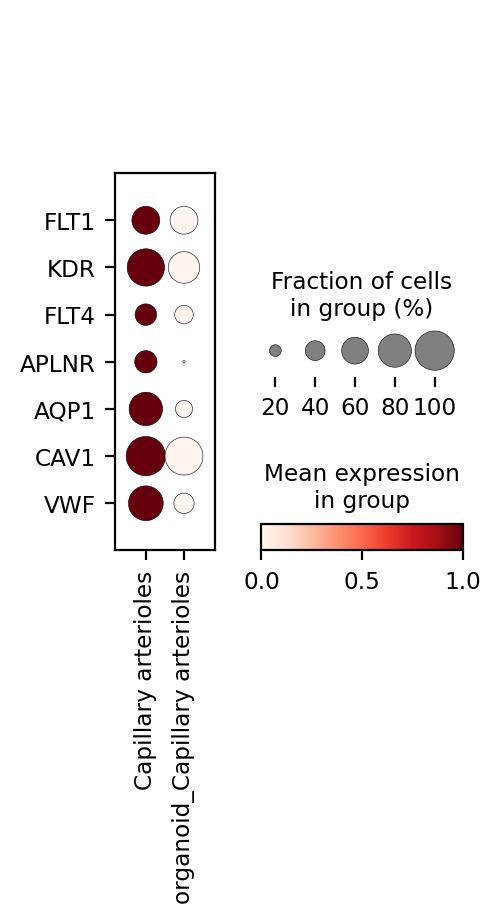

In [49]:
#combine VEGFR and pseudotime genes

combined_genes = ['FLT1', 'KDR', 'FLT4',
                  'APLNR', 'AQP1', 'CAV1', 'VWF']

sc.pl.dotplot(pdata2_caparterioles, var_names=combined_genes,
              groupby='new_combined_anno', standard_scale='var', swap_axes=True, save='VEGFR_pseudotime_genes.pdf')